# ML_FeatureEng_DataPrep

Credits:

- [2021 Python for Machine Learning & Data Science Masterclass by Jose Portilla Udemy](https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/)

In the real world, not every data set is machine learning ready, we often need to perform data cleaning or try to produce more usable features.

What is feature engineering? 
- Is the process of using domain knowledge to extract features from raw data via data mining techniques.
- Three general approaches:
    - Extracting Information
        - Imagine a dataset with visitor expenditure information for a bar. We have a timestamp for each row: *1990-12-01 09:26:03*. In its current format, its very difficult to pass into a machine learning algorithm. There is no coefficient we can apply for a non-numeric data point. In general for most algorithms we need to make sure features are float or int. Instead we extract information: year, month, weekday/ weekend etc.
    - Combining Information
        - Recall advertising spend could have possible interaction terms to consider, so we could multiply them together.
    - Transforming Information
        - Very common for string data. Most algorithms can not accept string data (can’t multiply a string such as “red” by a numeric coefficient)
        - We can use two approaches here:
            - **Integer Encoding**: Directly convert categories into integers 1,2,3...N. Possible issue is implied ordering and relationship (ordinal variable) which may/ may not make sense depending on the feature and the domain.
            
            <img src="images/FE1.png" style="float:center;" alt="drawing" width="700"/>
                
                - Pros: Very easy to do and understand. Does not increase number of features.
                - Cons: Implies ordered relationship between categories.

            - **One-hot Encoding** (Dummy Variables): Convert each category into individual features that are either 0 or 1. No ordered relationship is implied between categories. We can try to reduce this feature column expansion by creating higher level categories (comes from domain experience). For example, regions or continents instead of countries. Using pandas .map() or .apply() can achieve this.
            <img src="images/FE2.png" style="float:center;" alt="drawing" width="350"/>
            
                - Also must be aware of the “dummy variable trap”, mathematically known as multi-collinearity. Converting to dummy variables can cause features to be duplicated.
             <img src="images/FE3.png" style="float:center;" alt="drawing" width="700"/>

                - Use Pandas [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies)
                - Pros: No ordering implied.
                - Cons: Potential to create many more feature columns and coefficients. Dummy variable trap consideration. Not easy to add new categories.
                
            <img src="images/FE1.png" style="float:center;" alt="drawing" stylr="width:700px"/>

<a id='toc'></a>

Throughout this section of the course we’ll work on addressing the following issues:
- [Outliers](#1)
    - Range and Limits: we need to decide what will constitute an outlier with some methodology:
        - InterQuartile Range
        - Standard Deviation
        - Visualized or Domain Limit Value
    - Percentage of Data
        - Keep in mind if a large percentage of your data is being labeled as an outlier, then you actually just have a wide distribution, not outliers!
        - Limit outliers to a few percentage points a most.

- [Missing Data](#2)
    - Fill in the missing values
        - Potentially changing ground truth in data by "making" up a new data.
        - Must decide on reasonable estimation to filled value.
        - Must apply transformation to all future data for predictions.
        - For a low to moderate number of null values, try filling-in the date.
        - [Imputation](https://scikit-learn.org/stable/modules/impute.html): To impute missing data, we need to decide what other filled in (no NaN values) feature most probably relates and is correlated with the missing feature data. Fill-in with an *Statistical* estimation based of another column. Pandas *groupby()* and [*transform()*](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html) functions are handy for such imputations. 

    - Drop the feature column
        - Very simple to do.
        - No longer need to worry about that feature in the future.
        - Potential to lose a feature with possible important signal.
        - Should consider drop feature approach when many rows are NaN.
        -  If only a few rows relative to the size of your dataset are missing some values, then it might just be a good idea to drop those rows. What does this cost you in terms of performace? It essentialy removes potential training/testing data, but if its only a few rows, its unlikely to change performance. 
        - Sometimes it is a good idea to remove a feature entirely if it has too many null values. However, you should carefully consider why it has so many null values, in certain situations null could just be used as a separate category. Take for example a feature column for the number of cars that can fit into a garage. Perhaps if there is no garage then there is a null value, instead of a zero. It probably makes more sense to quickly fill the null values in this case with a zero instead of a null. Only you can decide based off your domain expertise and knowledge of the data set!
        - Let's explore how to choose to remove or fill in missing data for rows that are missing some data. Let's choose some threshold where we decide it is ok to drop a row if its missing some data (instead of attempting to fill in that missing data point). We will choose 1% as our threshold. This means if less than 1% of the rows are missing this feature, we will consider just dropping that row, instead of dealing with the feature itself. There is no right answer here, just use common sense and your domain knowledge of the dataset, obviously you don't want to drop a very high threshold like 50% , you should also explore correlation to the dataset, maybe it makes sense to drop the feature instead. Based on the text description of the features, you will see that most of this missing data is actually NaN on purpose as a placeholder for 0 or "none".
- [Categorical Data](#3)
    - Convert interger encoded data to string datatype (object dtype in pd)
    - Perform One-hot Encoding to generate dummy features
    - Make sure to avoid the multi-collinearity (dummy variable trap)

Not every issue here is strictly “feature engineering”, but could also be called “data cleaning”.    

<a id='1'></a>
## Outliers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# a set of ages
def create_ages(mu=50,sigma=13,n_samples=100,seed=42):
    # set the random seed in the same cell as the random call
    np.random.seed(seed)
    
    ages = np.random.normal(loc=mu,scale=sigma,size=n_samples)
    ages = np.round(ages,decimals=0)
    
    return ages

sample = create_ages()

#### Check for an outlier using displot

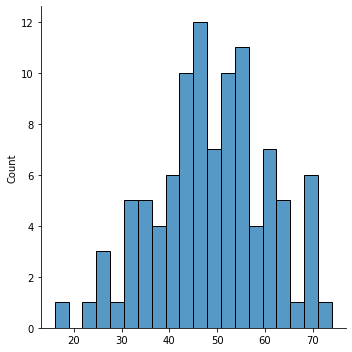

In [3]:
sns.displot(sample,bins=20);

#### Check for an outlier using boxplot

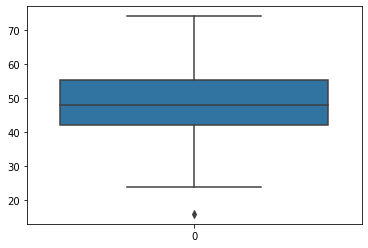

In [4]:
sns.boxplot(data=sample);

#### Filter out the outlier manually

In [5]:
ser = pd.Series(sample)
ser.describe() # q75=55.25, q25=42.0

IQR = 55.25 - 42.0
lower_limit = 42.0 - 1.5*IQR
print('Lower limit = ', lower_limit, '\n')

newser = ser[ser>lower_limit] # get rid of the outlier
newser

Lower limit =  22.125 



0     56.0
1     48.0
2     58.0
3     70.0
4     47.0
      ... 
95    31.0
96    54.0
97    53.0
98    50.0
99    47.0
Length: 99, dtype: float64

#### Filter out the outlier using numpy

In [6]:
q75, q25 = np.percentile(sample,[75,25])

IQR = q75 - q25
lower_limit = q25 - 1.5*IQR
print('Lower limit = ', lower_limit, '\n')

newser = ser[ser>lower_limit] # get rid of the outlier
newser

Lower limit =  22.125 



0     56.0
1     48.0
2     58.0
3     70.0
4     47.0
      ... 
95    31.0
96    54.0
97    53.0
98    50.0
99    47.0
Length: 99, dtype: float64

#### Filter out the outliers using domain knowledge

In [7]:
# Real housing price data with 81 features
df = pd.read_csv('data/Ames_Housing_Data.csv')
df.sample(5)

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1698,528112150,20,RL,98.0,11428,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,250000
206,903454060,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000
2132,907192120,20,RL,72.0,10665,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,226000
214,904352190,190,RH,60.0,6048,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,COD,Normal,114900
1643,527301080,20,RL,NaN,12546,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,182900


In [8]:
# Check the correlation of the output with all the features
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Screen Porch       0.112151
Pool Area          0.068403
Mo Sold            0.035259
3Ssn Porch         0.032225
BsmtFin SF 2       0.005891
Misc Val          -0.015691
Yr Sold           -0.030569
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0.085092
Overall Cond      -0.101697
Kitchen AbvGr     -0

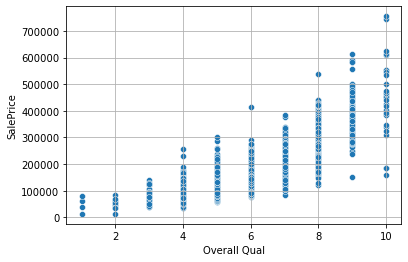

In [9]:
# Seems like SalePrice is closely related to the
# Overall Qaulity, so lets look at the scatter plot
sns.scatterplot(x='Overall Qual',y='SalePrice',data=df);
plt.grid()

- Notice that there are some houses rated 9 or 10 that priced at about the same as the houses rated 4 or 5, while there are some houses on the other end of spectrum, selling for way more than you would expect for its quality rating.

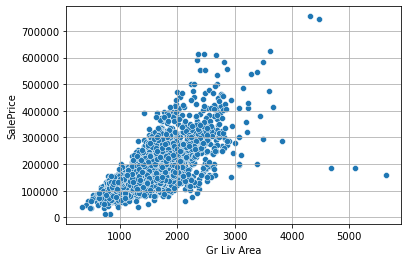

In [10]:
# seems like SalePrice is closely related to the
# Gr Liv Area, so lets look at the scatter plot
sns.scatterplot(x='Gr Liv Area',y='SalePrice',data=df);
plt.grid()

- Notice that there are some houses (three) with very high Living Area yet their prices are very low, while there are some houses with lower Living Area with very high prices.

In [11]:
# Grab those outliers with Pandas
outliers = df[(df['Overall Qual']>8) & (df['Gr Liv Area']>4000) & (df['SalePrice']<200000)]
drop_idx = outliers.index
drop_idx

Int64Index([1498, 2180, 2181], dtype='int64')

In [12]:
# Remove the outliers
df = df.drop(drop_idx,axis=0)

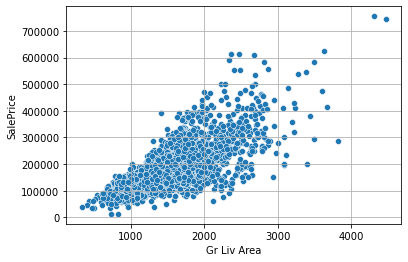

In [13]:
# check if the outliers are removed correctly
sns.scatterplot(x='Gr Liv Area',y='SalePrice',data=df);
plt.grid()

In [14]:
# save the new data
df.to_csv('data/Ames_Housing_Data_outliers_removed.csv',index=False)

[top](#toc)

<a id='2'></a>
## Missing Data

In [15]:
# Read in the txt file for the description of the features
with open('data/Ames_Housing_Feature_Description.txt', 'r') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [16]:
# Read in the data without outliers
df = pd.read_csv('data/Ames_Housing_Data_outliers_removed.csv')
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [17]:
# Drop PID as it has no value for the ML model
df = df.drop('PID',axis=1)

In [18]:
# Check what features are missing
df.isnull().sum()

MS SubClass         0
MS Zoning           0
Lot Frontage      490
Lot Area            0
Street              0
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 80, dtype: int64

In [19]:
# A function to calculate the percentage of 
# data missing for all the features
def percentage_missing(df):
    percent_nan = df.isnull().sum() / len(df) * 100
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan

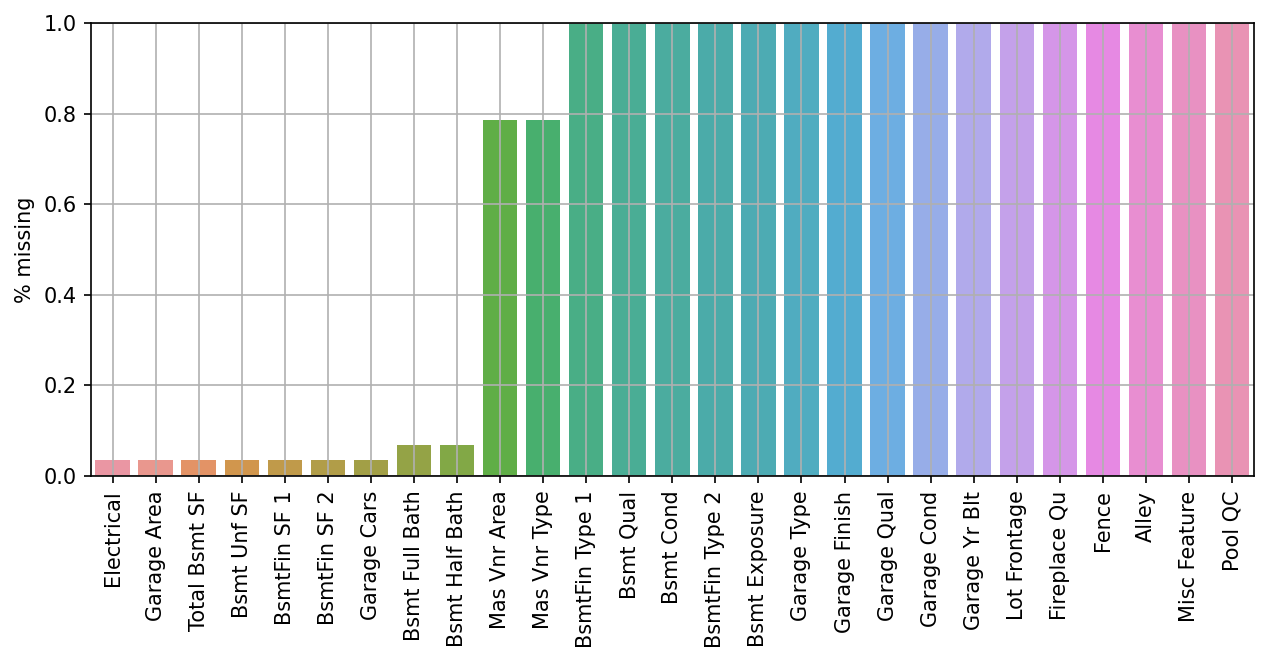

In [20]:
# Report percentage of what is missing and make a barplot
percent_nan = percentage_missing(df)

plt.figure(figsize=(10,4), dpi=150)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);
plt.ylabel('% missing')
plt.ylim(0,1)
plt.grid()

From the above barplot:
- In the case of just a few rows missing the feature data, we’ll consider either dropping these few rows or filling in with a reasonable assumption based off domain knowledge.

In [21]:
# Lets find out which rows are missing very low (<1%) of data
percent_nan[percent_nan<1]

Electrical        0.034165
Garage Area       0.034165
Total Bsmt SF     0.034165
Bsmt Unf SF       0.034165
BsmtFin SF 1      0.034165
BsmtFin SF 2      0.034165
Garage Cars       0.034165
Bsmt Full Bath    0.068329
Bsmt Half Bath    0.068329
Mas Vnr Area      0.785787
Mas Vnr Type      0.785787
dtype: float64

In [22]:
#one_percent
1/len(df)*100

0.0341646737273659

- So the features Electrical --> Garage Cars are only missing data in one row.
While, Bsmt Full Bath and Bsmt Half Bath are only missing two rows.

In [23]:
df[df['Electrical'].isnull()]['Garage Area']

1576    400.0
Name: Garage Area, dtype: float64

In [24]:
df[df['Bsmt Full Bath'].isnull()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1341,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,...,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml,79000
1497,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,284700


In [25]:
# Drop rows where at least Electrical and Garage Cars are missing 
df = df.dropna(axis=0,subset=['Electrical','Garage Cars'])

In [26]:
# Report percentage of what is missing and make a barplot
percent_nan = percentage_missing(df)
percent_nan[percent_nan<1]

Bsmt Unf SF       0.034188
Total Bsmt SF     0.034188
BsmtFin SF 2      0.034188
BsmtFin SF 1      0.034188
Bsmt Full Bath    0.068376
Bsmt Half Bath    0.068376
Mas Vnr Type      0.786325
Mas Vnr Area      0.786325
dtype: float64

- Along with Electrical and Garage Cars, a couple of more features with null values got removed sharing the same rows.
- Notice that a lot of these feautes are related to Basement and it may be the case that some of the houses don't have a basement. Lets check!

In [27]:
df[df['Bsmt Full Bath'].isnull()][['Bsmt Half Bath','Bsmt Unf SF','Total Bsmt SF']]

,Bsmt Half Bath,Bsmt Unf SF,Total Bsmt SF
1341,NaN,NaN,NaN
1497,NaN,0.0,0.0


- So from a domain knowledge (after taking a look at the features description) we can conclude that these houses just doesn't have a Basement. For the numerical features we can set those values to 0 and for other feautures we can fill them up wit a string 'None' and see what can we do later about it. Note that the 'None' value is a placeholder for the absense of the feature based on domain knowledge.

In [28]:
# Fill in the Basement related catagorical features
bsmt_num_cols = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',\
                 'Total Bsmt SF','Bsmt Full Bath','Bsmt Half Bath']
df[bsmt_num_cols] = df[bsmt_num_cols].fillna(0)

# Fill in the Basement related numeric features
bsmt_str_cols =  ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
df[bsmt_str_cols] = df[bsmt_str_cols].fillna('None')

In [29]:
# Report percentage of what is missing and make a barplot
percent_nan = percentage_missing(df)
percent_nan[percent_nan<1]

Mas Vnr Type    0.786325
Mas Vnr Area    0.786325
dtype: float64

- Now we are only left with two features with missing data of <1%. Again after looking into these two above features, we can fill in  Mas Vnr Type with 'None' and Mas Vnr Area with 0 values.

In [30]:
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None') # catagorical
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)      # numerical

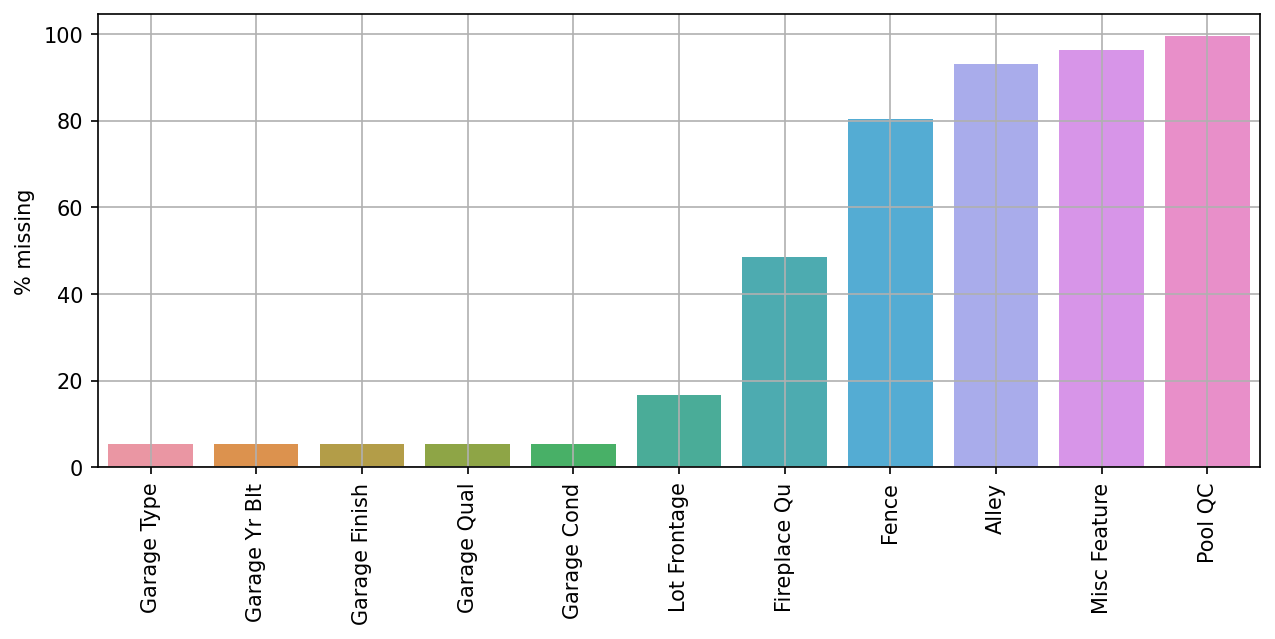

In [31]:
percent_nan = percentage_missing(df)

plt.figure(figsize=(10,4), dpi=150)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);
plt.ylabel('% missing')
plt.grid()

- Notice that, similar to features related to Basement, now a lot of feautes are related to Garage are missing. Again we check the description of the features and can reasonably fill-in catagorical column related to Garage with 'None' and a numrical column with 0 values. 

In [32]:
# Fill in the Garage related catagorical features
gar_str_cols = ['Garage Type', 'Garage Finish','Garage Qual','Garage Cond']
df[gar_str_cols] = df[gar_str_cols].fillna('None')

# Fill in the Garage related numeric features
# NOTE - the year 0 implies here that the house doesn't have a Garage
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(0)

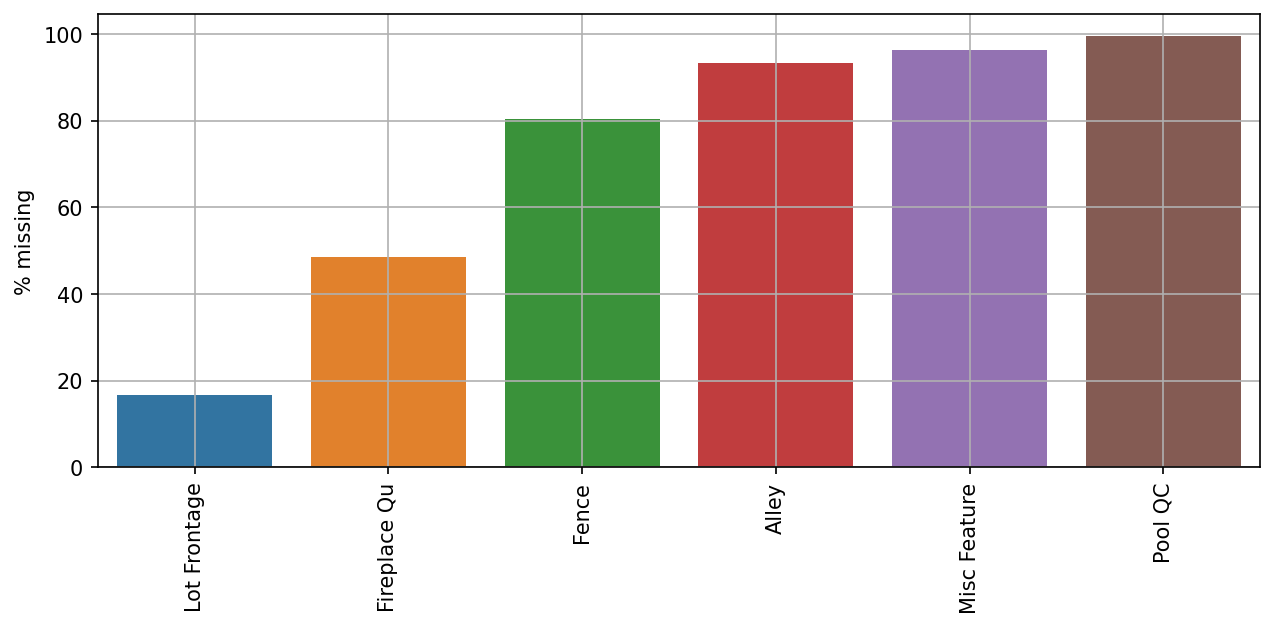

In [33]:
percent_nan = percentage_missing(df)

plt.figure(figsize=(10,4), dpi=150)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);
plt.ylabel('% missing')
plt.grid()

- Now we are left with missing data in only six features
- First we will just drop all these features with >=80% missing data

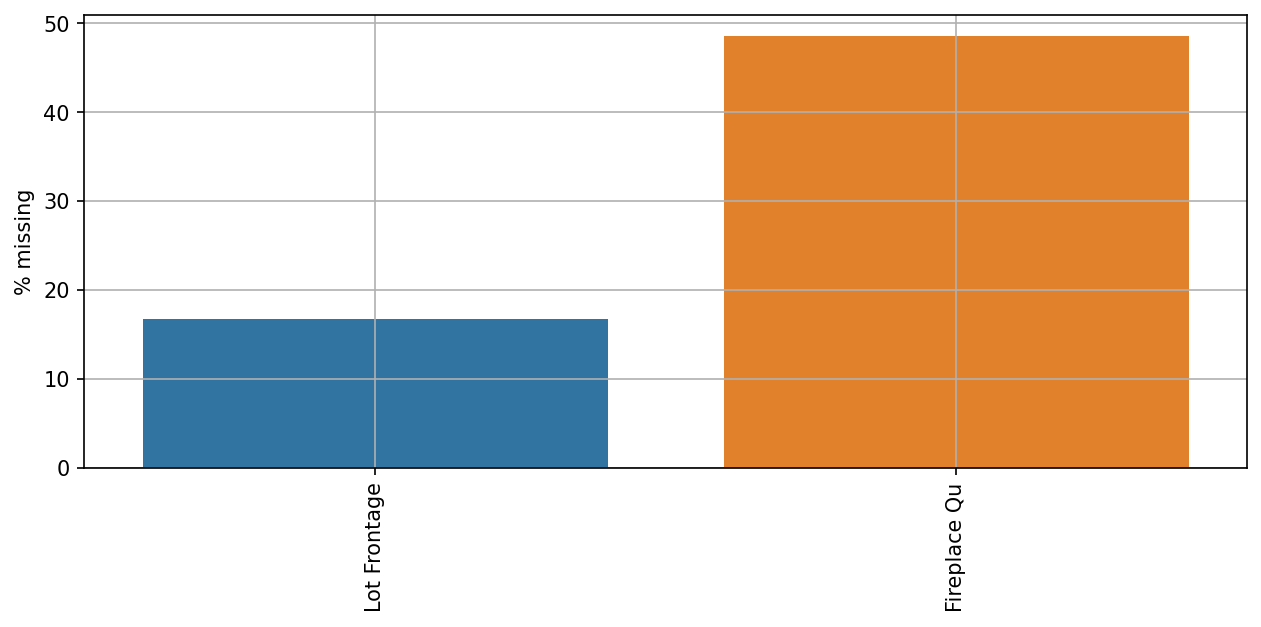

In [34]:
df = df.drop(['Pool QC','Misc Feature','Alley','Fence'],axis=1)

percent_nan = percentage_missing(df)

plt.figure(figsize=(10,4), dpi=150)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);
plt.ylabel('% missing')
plt.grid()

- Now we are left with only two features with missing data. However, these features are not on the extreme side of mising data but somewhere in b/w. So we need to make an informed decision about then (remove / fill-in).
- For Fireplace Qu fillning 'None' assuming the absence of a Fireplace in the house.
- While for Lot Frontage we fill-in with an *Statistical* estimation based of another feature (Neighborhood).
    - Neighborhood: Physical locations within Ames city limits
    - LotFrontage: Linear feet of street connected to property
    
 We will operate under the assumption that the Lot Frontage is related to what neighborhood a house is in. So we may fill-in the missing Lot Frontage value(s) with the mean(s) of Lot Frontages for that plarticular neighborhood in which the house is in.

In [35]:
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')

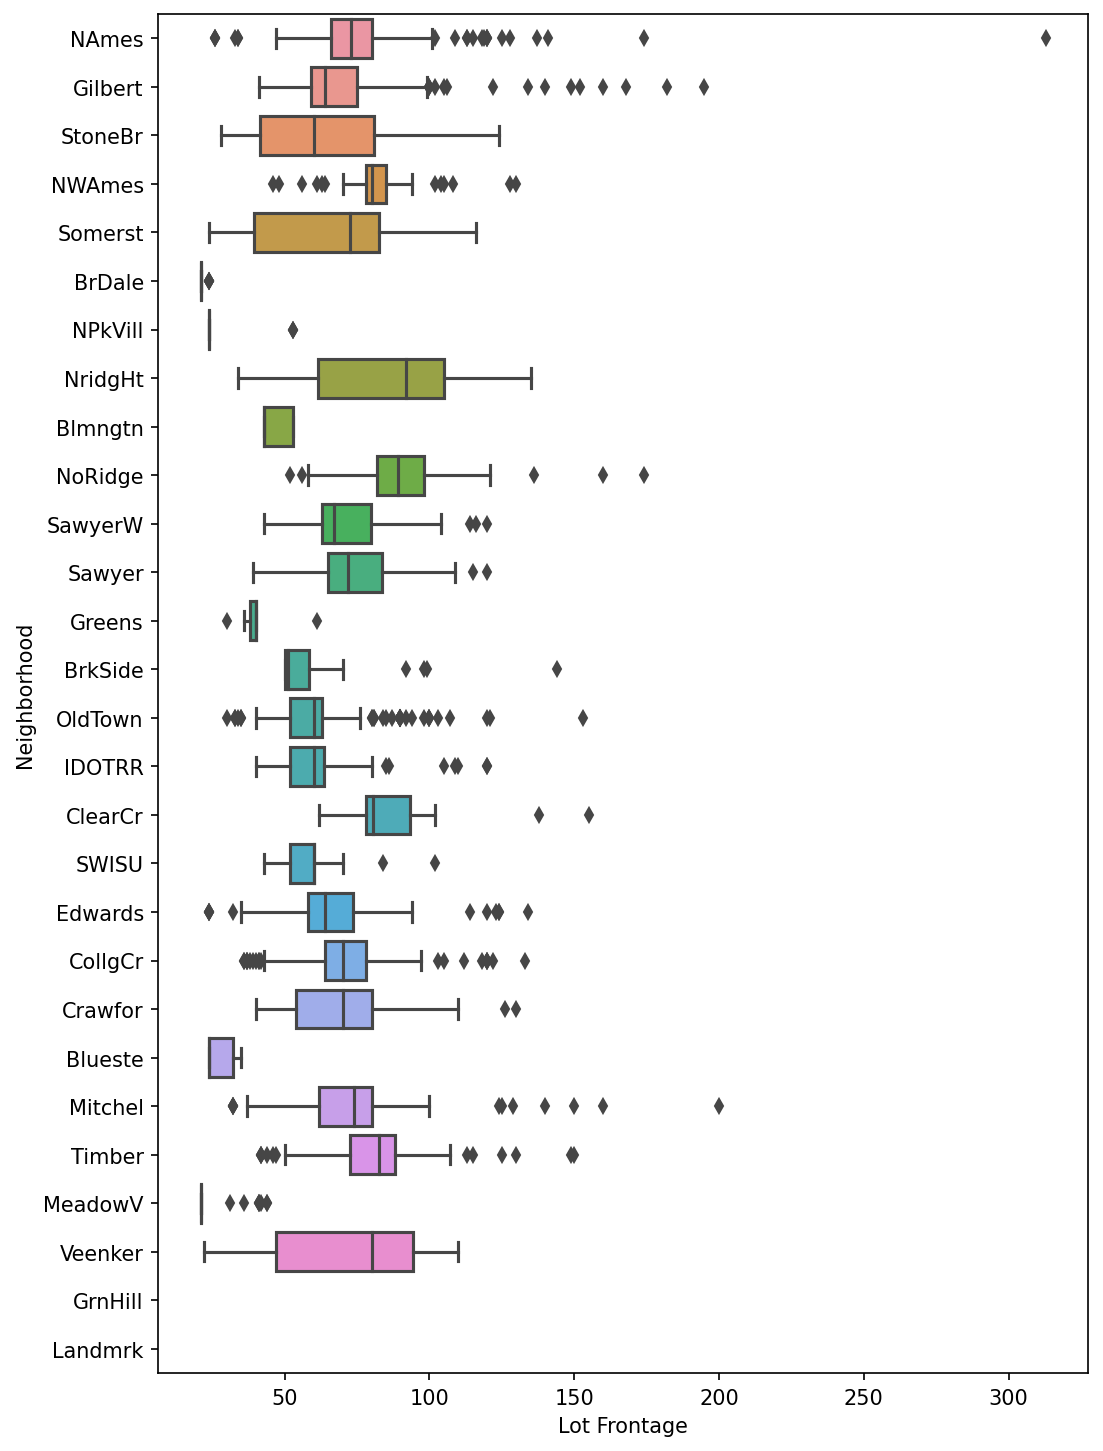

In [36]:
plt.figure(figsize=(8,12),dpi=150)
sns.boxplot(x='Lot Frontage',y='Neighborhood',data=df,orient='h');

In [37]:
df.groupby('Neighborhood')['Lot Frontage'].mean()

Neighborhood
Blmngtn    46.900000
Blueste    27.300000
BrDale     21.500000
BrkSide    55.789474
ClearCr    88.150000
CollgCr    71.336364
Crawfor    69.951807
Edwards    64.794286
Gilbert    74.207207
Greens     41.000000
GrnHill          NaN
IDOTRR     62.383721
Landmrk          NaN
MeadowV    25.606061
Mitchel    75.144444
NAmes      75.210667
NPkVill    28.142857
NWAmes     81.517647
NoRidge    91.629630
NridgHt    84.184049
OldTown    61.777293
SWISU      59.068182
Sawyer     74.551020
SawyerW    70.669811
Somerst    64.549383
StoneBr    62.173913
Timber     81.303571
Veenker    72.000000
Name: Lot Frontage, dtype: float64

In [38]:
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].\
                     transform(lambda val: val.fillna(val.mean()))

df['Lot Frontage'].isnull().sum()

3

- We still have 3 rows with missing values for Lot Frontage. This is because for some Neighborhoods mean is not available. So we'll just fill-in them with 0 value. 

In [39]:
df['Lot Frontage'] = df['Lot Frontage'].fillna(0)
df.isnull().sum()

MS SubClass       0
MS Zoning         0
Lot Frontage      0
Lot Area          0
Street            0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 76, dtype: int64

In [40]:
# Final check
percent_nan = percentage_missing(df)
percent_nan

Series([], dtype: float64)

- We have now dealt with all the missing data.

In [41]:
# Save the data
df.to_csv('data/Ames_Housing_Data_no_more_missing_data.csv',index=False)

[top](#toc)

<a id='3'></a>
## Categorical Data

In [42]:
df = pd.read_csv('data/Ames_Housing_Data_no_more_missing_data.csv')
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,WD,Normal,189900


- The catagorical features to be consodered - MSSubClass (integer encoded)

        MSSubClass: Identifies the type of dwelling involved in the sale.

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        
- The number itself does not appear to have a relationship to the other numbers. While 30 > 20 is True, it doesn't really make sense that "1-STORY 1945 & OLDER" > "1-STORY 1946 & NEWER ALL STYLES". Keep in mind, this isn't always the case, for example 1st class seats versus 2nd class seats encoded as 1 and 2. Make sure you fully understand your data set to examine what needs to be converted/changed.

In [43]:
# Step 1 : Convert to String
df['MS SubClass'] = df['MS SubClass'].apply(str)

In [44]:
# Step 2 : Grab all the features with string and non-string datatypes
# NOTE : Pandas defines a string datatype as 'object' dtype
df_object = df.select_dtypes(include='object')
df_numeric = df.select_dtypes(exclude='object')

print(df_object.head(2))
print(df_numeric.head(2))

  MS SubClass MS Zoning Street Lot Shape Land Contour Utilities Lot Config  \
0          20        RL   Pave       IR1          Lvl    AllPub     Corner   
1          20        RH   Pave       Reg          Lvl    AllPub     Inside   

  Land Slope Neighborhood Condition 1  ... Kitchen Qual Functional  \
0        Gtl        NAmes        Norm  ...           TA        Typ   
1        Gtl        NAmes       Feedr  ...           TA        Typ   

  Fireplace Qu Garage Type Garage Finish Garage Qual Garage Cond Paved Drive  \
0           Gd      Attchd           Fin          TA          TA           P   
1         None      Attchd           Unf          TA          TA           Y   

  Sale Type Sale Condition  
0       WD          Normal  
1       WD          Normal  

[2 rows x 40 columns]
   Lot Frontage  Lot Area  Overall Qual  Overall Cond  Year Built  \
0         141.0     31770             6             5        1960   
1          80.0     11622             5             6        1961

In [45]:
# Step 3: Create "Dummy" Variables for all the string features in DataFrame
# Avoiding MultiCollinearity using 'drop_first=True'
df_objects_dummies = pd.get_dummies(df_object,drop_first=True)
df_objects_dummies.head()

,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [46]:
# Step 4 : Concatenate the df_objects_dummies and df_numeric DataFrames
df_final = pd.concat([df_numeric,df_objects_dummies],axis=1)
df_final.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,...,0,0,0,0,1,0,0,0,1,0
1,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,0,1,0,0,0,1,0
2,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,0,1,0,0,0,1,0
3,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,...,0,0,0,0,1,0,0,0,1,0
4,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,0,1,0,0,0,1,0


- We will use regularization later on to help us choose important feautres! 

In [47]:
df_final.corr()['SalePrice'].sort_values(ascending=False)

SalePrice            1.000000
Overall Qual         0.802637
Gr Liv Area          0.727279
Total Bsmt SF        0.660983
Garage Cars          0.648488
                       ...   
Garage Finish_Unf   -0.422363
Bsmt Qual_TA        -0.453022
Fireplace Qu_None   -0.481740
Kitchen Qual_TA     -0.527461
Exter Qual_TA       -0.591459
Name: SalePrice, Length: 274, dtype: float64

In [48]:
# Save data
df_final.to_csv('data/Ames_Housing_Data_cleaned_prepared_data.csv',index=False)

In [49]:
from IPython.core.display import display, HTML
display(HTML('<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))